<a href="https://colab.research.google.com/github/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_12_04_atari.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# T81-558: Applications of Deep Neural Networks
**Module 12: Reinforcement Learning**
* Instructor: [Jeff Heaton](https://sites.wustl.edu/jeffheaton/), McKelvey School of Engineering, [Washington University in St. Louis](https://engineering.wustl.edu/Programs/Pages/default.aspx)
* For more information visit the [class website](https://sites.wustl.edu/jeffheaton/t81-558/).

# Module 12 Video Material

* Part 12.1: Introduction to the OpenAI Gym [[Video]](https://www.youtube.com/watch?v=_KbUxgyisjM&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](t81_558_class_12_01_ai_gym.ipynb)
* Part 12.2: Introduction to Q-Learning [[Video]](https://www.youtube.com/watch?v=uwcXWe_Fra0&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](t81_558_class_12_02_qlearningreinforcement.ipynb)
* Part 12.3: Keras Q-Learning in the OpenAI Gym [[Video]](https://www.youtube.com/watch?v=Ya1gYt63o3M&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](t81_558_class_12_03_keras_reinforce.ipynb)
* **Part 12.4: Atari Games with Keras Neural Networks** [[Video]](https://www.youtube.com/watch?v=t2yIu6cRa38&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](t81_558_class_12_04_atari.ipynb)
* Part 12.5: How Alpha Zero used Reinforcement Learning to Master Chess [[Video]](https://www.youtube.com/watch?v=ikDgyD7nVI8&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](t81_558_class_12_05_alpha_zero.ipynb)


# Google CoLab Instructions

The following code ensures that Google CoLab is running the correct version of TensorFlow, and has the necessary Python libraries installed.

In [1]:
try:
    from google.colab import drive
    %tensorflow_version 2.x
    COLAB = True
    print("Note: using Google CoLab")
except:
    print("Note: not using Google CoLab")
    COLAB = False

if COLAB:
  !sudo apt-get install -y xvfb ffmpeg
  !pip install -q 'gym==0.10.11'
  !pip install -q 'imageio==2.4.0'
  !pip install -q PILLOW
  !pip install -q 'pyglet==1.3.2'
  !pip install -q pyvirtualdisplay
  !pip install -q --upgrade tensorflow-probability
  !pip install -q tf-agents

Note: using Google CoLab
Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.6-0ubuntu0.18.04.1).
xvfb is already the newest version (2:1.19.6-1ubuntu4.4).
0 upgraded, 0 newly installed, 0 to remove and 31 not upgraded.


# Part 12.4: Atari Games with Keras Neural Networks


The Atari 2600 is a home video game console from Atari, Inc. Released on September 11, 1977. It is credited with popularizing the use of microprocessor-based hardware and games stored on ROM cartridges instead of dedicated hardware with games physically built into the unit. The 2600 was bundled with two joystick controllers, a conjoined pair of paddle controllers, and a game cartridge: initially [Combat](https://en.wikipedia.org/wiki/Combat_(Atari_2600)), and later [Pac-Man](https://en.wikipedia.org/wiki/Pac-Man_(Atari_2600)).

Atari emulators are popular and allow many of the old Atari video games to be played on modern computers.  They are even available as JavaScript.

* [Virtual Atari](http://www.virtualatari.org/listP.html)

Atari games have become popular benchmarks for AI systems, particularly reinforcement learning.  OpenAI Gym internally uses the [Stella Atari Emulator](https://stella-emu.github.io/). The Atari 2600 is shown in Figure 12.ATARI.

**Figure 12.ATARI: The Atari 2600**
![Atari 2600 Console](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/atari-1.png "Atari 2600 Console")

### Actual Atari 2600 Specs

* CPU: 1.19 MHz MOS Technology 6507
* Audio + Video processor: Television Interface Adapter (TIA)
* Playfield resolution: 40 x 192 pixels (NTSC). Uses a 20-pixel register that is mirrored or copied, left side to right side, to achieve the width of 40 pixels.
* Player sprites: 8 x 192 pixels (NTSC). Player, ball, and missile sprites use pixels that are 1/4 the width of playfield pixels (unless stretched).
* Ball and missile sprites: 1 x 192 pixels (NTSC).
* Maximum resolution: 160 x 192 pixels (NTSC). Max resolution is only somewhat achievable with programming tricks that combine sprite pixels with playfield pixels.
* 128 colors (NTSC). 128 possible on screen. Max of 4 per line: background, playfield, player0 sprite, and player1 sprite. Palette switching between lines is common. Palette switching mid line is possible but not common due to resource limitations.
* 2 channels of 1-bit monaural sound with 4-bit volume control.

### OpenAI Lab Atari Pong

OpenAI Gym can be used with Windows; however, it requires a special [installation procedure].(https://towardsdatascience.com/how-to-install-openai-gym-in-a-windows-environment-338969e24d30)  

This chapter demonstrates playing [Atari Pong](https://github.com/wau/keras-rl2/blob/master/examples/dqn_atari.py). Pong is a two-dimensional sports game that simulates table tennis. The player controls an in-game paddle by moving it vertically across the left or right side of the screen. They can compete against another player controlling a second paddle on the opposing side. Players use the paddles to hit a ball back and forth. The goal is for each player to reach eleven points before the opponent; you earn points when one fails to return it to the other.  For the Atari 2600 version of Pong, a computer player (controlled by the 2600) is the opposing player.

This section shows how to adapt TF-Agents to an Atari game.  Some changes are necessary when compared to the pole-cart game presented earlier in this chapter. You can quickly adapt this example to any Atari game by simply changing the environment name.  However, I tuned the code presented here for Pong, and it may not perform as well for other games.  Some tuning will likely be necessary to produce a good agent for other games.

We begin by importing the needed Python packages.

In [0]:
import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import pyvirtualdisplay

import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym, suite_atari
from tf_agents.environments import tf_py_environment, batched_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import q_network
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

from tf_agents.specs import tensor_spec
from tf_agents.trajectories import time_step as ts

In [0]:
# Set up a virtual display for rendering OpenAI gym environments.
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

## Hyperparameters

The hyperparameter names are the same as the previous DQN example; however, I tuned the numeric values for the more complex Atari game.

In [0]:
num_iterations = 250000 

initial_collect_steps = 5000  
collect_steps_per_iteration = 10 
replay_buffer_max_length = 100000

batch_size =   32
learning_rate = 2.5e-4  
log_interval =   5000

num_eval_episodes = 5  
eval_interval = 25000  

The algorithm needs more iterations for an Atari game.  I also found that increasing the number of collection steps helped the algorithm to train.

## Atari Environment's

You must handle Atari environments differently than games like cart-poll.  Atari games typically use their 2D displays as the environment state.  AI Gym represents Atari games as either a 3D (height by width by color) state spaced based on their screens, or a vector representing the state of the gam's computer RAM. To preprocess Atari games for greater computational efficiency, we generally skip several frames, decrease the resolution, and discard color information.  The following code shows how we can set up an Atari environment.

In [0]:
#env_name = 'Breakout-v4'
env_name = 'Pong-v0'
#env_name = 'BreakoutDeterministic-v4'
#env = suite_gym.load(env_name)

# AtariPreprocessing runs 4 frames at a time, max-pooling over the last 2
# frames. We need to account for this when computing things like update
# intervals.
ATARI_FRAME_SKIP = 4

max_episode_frames=108000  # ALE frames

env = suite_atari.load(
    env_name,
    max_episode_steps=max_episode_frames / ATARI_FRAME_SKIP,
    gym_env_wrappers=suite_atari.DEFAULT_ATARI_GYM_WRAPPERS_WITH_STACKING)
#env = batched_py_environment.BatchedPyEnvironment([env])

We can now reset the environment and display one step.  The following image shows how the Pong game environment appears to a user.

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: <class 'tf_agents.environments.atari_preprocessing.AtariPreprocessing'> doesn't implement 'reset' method, which is required for wrappers derived directly from Wrapper. Deprecated default implementation is used.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


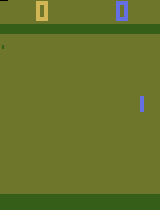

In [6]:
env.reset()
PIL.Image.fromarray(env.render())

We are now ready to load and wrap the two environments for TF-Agents. The algorithm uses the first environment for evaluation, and the second to train.

In [0]:
train_py_env = suite_atari.load(
    env_name,
    max_episode_steps=max_episode_frames / ATARI_FRAME_SKIP,
    gym_env_wrappers=suite_atari.DEFAULT_ATARI_GYM_WRAPPERS_WITH_STACKING)

eval_py_env = suite_atari.load(
    env_name,
    max_episode_steps=max_episode_frames / ATARI_FRAME_SKIP,
    gym_env_wrappers=suite_atari.DEFAULT_ATARI_GYM_WRAPPERS_WITH_STACKING)

train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

## Agent

I used the following class, from TF-Agents examples, to wrap the regular Q-network class.  The AtariQNetwork class ensures that the pixel values from the Atari screen are divided by 255.  This division assists the neural network by normalizing the pixel values to between 0 and 1.

In [0]:
class AtariQNetwork(q_network.QNetwork):
  """QNetwork subclass that divides observations by 255."""

  def call(self,
           observation,
           step_type=None,
           network_state=(),
           training=False):
    state = tf.cast(observation, tf.float32)
    # We divide the grayscale pixel values by 255 here rather than storing
    # normalized values beause uint8s are 4x cheaper to store than float32s.
    state = state / 255
    return super(AtariQNetwork, self).call(
        state, step_type=step_type, network_state=network_state,
        training=training)

Next, we introduce two hyperparameters that are specific to the neural network we are about to define.

In [0]:
fc_layer_params = (512,)
conv_layer_params=((32, (8, 8), 4), (64, (4, 4), 2), (64, (3, 3), 1))

q_net = AtariQNetwork(
            train_env.observation_spec(),
            train_env.action_spec(),
            conv_layer_params=conv_layer_params,
            fc_layer_params=fc_layer_params)

Convolutional neural networks usually are made up of several alternating pairs of convolution and max-pooling layers, ultimately culminating in one or more dense layers.  These layers are the same types as previously seen in this course.  The QNetwork accepts two parameters that define the convolutional neural network structure. 

The more simple of the two parameters is **fc_layer_params**.  This parameter specifies the size of each of the dense layers.  A tuple specifies the size of each of the layers in a list. 

The second parameter, named **conv_layer_params**, is a list of convolution layers parameters, where each item is a length-three tuple indicating (filters, kernel_size, stride).  This implementation of QNetwork supports only convolution layers.  If you desire a more complex convolutional neural network, you must define your variant of the QNetwork.

The QNetwork defined here is not the agent, instead, the QNetwork is used by the DQN agent to implement the actual neural network. This allows flexibility as you can set your own class if needed.

Next, we define the optimizer.  For this example, I used RMSPropOptimizer.  However, AdamOptimizer is another popular choice.  We also create the DQN and reference the Q-network we just created.

In [0]:
optimizer = tf.compat.v1.train.RMSPropOptimizer(
    learning_rate=learning_rate,
    decay=0.95,
    momentum=0.0,
    epsilon=0.00001,
    centered=True)

train_step_counter = tf.Variable(0)

observation_spec = tensor_spec.from_spec(train_env.observation_spec())
time_step_spec = ts.time_step_spec(observation_spec)

action_spec = tensor_spec.from_spec(train_env.action_spec())
target_update_period=32000  # ALE frames
update_period=16  # ALE frames
_update_period = update_period / ATARI_FRAME_SKIP
_global_step = tf.compat.v1.train.get_or_create_global_step()

agent = dqn_agent.DqnAgent(
    time_step_spec,
    action_spec,
    q_network=q_net,
    optimizer=optimizer,
    epsilon_greedy=0.01,
    n_step_update=1.0,
    target_update_tau=1.0,
    target_update_period=(
        target_update_period / ATARI_FRAME_SKIP / _update_period),
    td_errors_loss_fn=common.element_wise_huber_loss,
    gamma=0.99,
    reward_scale_factor=1.0,
    gradient_clipping=None,
    debug_summaries=False,
    summarize_grads_and_vars=False,
    train_step_counter=_global_step)



agent.initialize()

## Metrics and Evaluation

There are many different ways to measure the effectiveness of a model trained with reinforcement learning.  The loss function of the internal Q-network is not a good measure of the entire DQN algorithm's overall fitness.  The network loss function measures how close the Q-network was fit to the collected data and did not indicate how effective the DQN is in maximizing rewards. The method used for this example tracks the average reward received over several episodes.

In [0]:
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]

## Replay Buffer

DQN works by training a neural network to predict the Q-values for every possible environment-state.  A neural network needs training data, so the algorithm accumulates this training data as it runs episodes. The replay buffer is where this data is stored.  Only the most recent episodes are stored, older episode data rolls off the queue as the queue accumulates new data.

In [0]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_max_length)

# Dataset generates trajectories with shape [Bx2x...]
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, 
    sample_batch_size=batch_size, 
    num_steps=2).prefetch(3)

## Random Collection

The algorithm must prime the pump.  Training cannot begin on an empty replay buffer.  The following code performs a predefined number of steps to generate initial training data.

In [0]:
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

def collect_step(environment, policy, buffer):
  time_step = environment.current_time_step()
  action_step = policy.action(time_step)
  next_time_step = environment.step(action_step.action)
  traj = trajectory.from_transition(time_step, action_step, next_time_step)

  # Add trajectory to the replay buffer
  buffer.add_batch(traj)

def collect_data(env, policy, buffer, steps):
  for _ in range(steps):
    collect_step(env, policy, buffer)

collect_data(train_env, random_policy, replay_buffer, steps=initial_collect_steps)

## Training the agent

We are now ready to train the DQN. This process can take many hours, depending on how many episodes you wish to run through.  As training occurs, this code will update on both the loss and average return.  As training becomes more successful, the average return should increase. The losses reported reflecting the average loss for individual training batches.

In [15]:
iterator = iter(dataset)

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

for _ in range(num_iterations):

  # Collect a few steps using collect_policy and save to the replay buffer.
  for _ in range(collect_steps_per_iteration):
    collect_step(train_env, agent.collect_policy, replay_buffer)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  train_loss = agent.train(experience).loss

  step = agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
    print('step = {0}: Average Return = {1}'.format(step, avg_return))
    returns.append(avg_return)

step = 5000: loss = 0.010096915997564793
step = 10000: loss = 0.029444240033626556
step = 15000: loss = 0.0049832831136882305
step = 20000: loss = 0.01718844845890999
step = 25000: loss = 0.009340734221041203
step = 25000: Average Return = -21.0
step = 30000: loss = 0.006228224840015173
step = 35000: loss = 0.004158324096351862
step = 40000: loss = 0.014960331842303276
step = 45000: loss = 0.013988891616463661
step = 50000: loss = 0.0053611560724675655
step = 50000: Average Return = -19.399999618530273
step = 55000: loss = 0.011948538944125175
step = 60000: loss = 0.013576810248196125
step = 65000: loss = 0.014345762319862843
step = 70000: loss = 0.013468008488416672
step = 75000: loss = 0.019563401117920876
step = 75000: Average Return = -17.600000381469727
step = 80000: loss = 0.006855367217212915
step = 85000: loss = 0.02645200304687023
step = 90000: loss = 0.028687894344329834
step = 95000: loss = 0.0077339960262179375
step = 100000: loss = 0.008796805515885353
step = 100000: Avera

## Visualization

The notebook can plot the average return over training iterations.  The average return should increase as the program performs more training iterations.

(-21.490000009536743, 10.0)

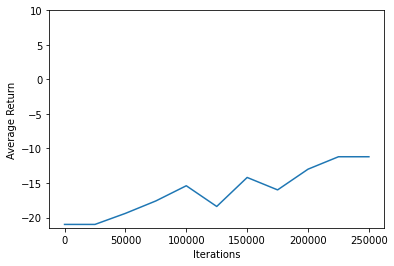

In [16]:
iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
plt.ylim(top=10)

## Videos

We now have a trained model and observed its training progress on a graph.  Perhaps the most compelling way to view an Atari game's results is a video that allows us to see the agent play the game. The following functions are defined so that we can watch the agent play the game in the notebook.

In [0]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

def create_policy_eval_video(policy, filename, num_episodes=5, fps=30):
  filename = filename + ".mp4"
  with imageio.get_writer(filename, fps=fps) as video:
    for _ in range(num_episodes):
      time_step = eval_env.reset()
      video.append_data(eval_py_env.render())
      while not time_step.is_last():
        action_step = policy.action(time_step)
        time_step = eval_env.step(action_step.action)
        video.append_data(eval_py_env.render())
  return embed_mp4(filename)

First, we will observe the trained agent play the game.

In [18]:
create_policy_eval_video(agent.policy, "trained-agent")

For comparison, we observe a random agent play.  While the trained agent is far from perfect, it does outperform the random agent by a considerable amount.

In [19]:
create_policy_eval_video(random_policy, "random-agent")